In [15]:
# user inputs

fileName = "trainSfCrime.csv"
targetVariable = "Category"
numericalFeatures = ["X", "Y"]
categoricalFeatures = []
features = []

In [16]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import cross_validation
from datetime import datetime
%matplotlib inline

train = pd.read_csv(fileName) 
smallTrain = train[:1000]
train = train[:10000]
#smallTrain
smallTrain[:4]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873


In [17]:
set(train["Category"])

{'ARSON',
 'ASSAULT',
 'BRIBERY',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'DRUNKENNESS',
 'EMBEZZLEMENT',
 'EXTORTION',
 'FAMILY OFFENSES',
 'FORGERY/COUNTERFEITING',
 'FRAUD',
 'GAMBLING',
 'KIDNAPPING',
 'LARCENY/THEFT',
 'LIQUOR LAWS',
 'LOITERING',
 'MISSING PERSON',
 'NON-CRIMINAL',
 'OTHER OFFENSES',
 'PROSTITUTION',
 'ROBBERY',
 'RUNAWAY',
 'SECONDARY CODES',
 'SEX OFFENSES FORCIBLE',
 'SEX OFFENSES NON FORCIBLE',
 'STOLEN PROPERTY',
 'SUICIDE',
 'SUSPICIOUS OCC',
 'TRESPASS',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS'}

In [18]:
set(train["Descript"])

{'ACCESS CARD INFORMATION, THEFT OF',
 'AGGRAVATED ASSAULT OF POLICE OFFICER,BODILY FORCE',
 'AGGRAVATED ASSAULT WITH A DEADLY WEAPON',
 'AGGRAVATED ASSAULT WITH A GUN',
 'AGGRAVATED ASSAULT WITH A KNIFE',
 'AGGRAVATED ASSAULT WITH BODILY FORCE',
 'AIDED CASE',
 'AIDED CASE -PROPERTY FOR DESTRUCTION',
 'AIDED CASE, DOG BITE',
 'AIDED CASE, INJURED PERSON',
 'AIDED CASE, MENTAL DISTURBED',
 'AIDED CASE, SICK PERSON',
 'AMMUNITION, POSS. BY PROHIBITED PERSON',
 'ANIMAL, FIGHTING',
 'ANNOY OR MOLEST CHILDREN',
 'ARMOR PENETRATING AMMUNITION, POSSESSION',
 'ARSON',
 'ARSON OF A VEHICLE',
 'ARSON OF AN INHABITED DWELLING',
 'ASSAULT',
 'ASSAULT ON A POLICE OFFICER WITH A DEADLY WEAPON',
 'ASSAULT TO RAPE WITH BODILY FORCE',
 'ASSAULT WITH CAUSTIC CHEMICALS',
 'ASSAULT, AGGRAVATED, W/ GUN',
 'ATM RELATED CRIME',
 'ATTEMPTED ARSON',
 'ATTEMPTED GRAND THEFT FROM PERSON',
 'ATTEMPTED GRAND THEFT PURSESNATCH',
 'ATTEMPTED HOMICIDE WITH A DANGEROUS WEAPON',
 'ATTEMPTED HOMICIDE WITH A GUN',
 'ATT

In [19]:
# feature engineering: crime categories

def collapseCategories(inputDataframe, 
                       superCatToSubCatMap, 
                       featureList, 
                       nameOfNewCategory):
    
    subCatToSuperCatMap = {}
    for superCat, subCatList in superCatToSubCatMap.iteritems():
        for subCat in subCatList:
            subCatToSuperCatMap[subCat] = superCat
    newCategoryValues = []
    for row in inputDataframe.iterrows():
        category = row[1]['Category']
        if category in subCatToSuperCatMap:
            newCategoryValues.append(subCatToSuperCatMap[category])
        else:
            newCategoryValues.append('others')
            
    inputDataframe[nameOfNewCategory] = newCategoryValues
    featureList.append(nameOfNewCategory)
    
def extendTrainingWithCrimeCategories(inputDataframe, featureList):
    moneyface = ['EMBEZZLEMENT', 'BURGLARY', 'BRIBERY', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING']
    foodie  = ['DRUG/NARCOTIC', 'DRUNKENNESS', 'LIQUOR LAWS', 'DRIVING UNDER THE INFLUENCE']
    emo = ['LOITERING', 'SUICIDE', 'RUNAWAY']
    violent = ['KIDNAPPING', 'WEAPON LAWS', 'ROBBERY', 'ASSAULT', 'DISORDERLY CONDUCT']
    lusty = ['PROSTITUTION', 'SEX OFFENSES FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE']
    nonlivingthings = ['RECOVERED VEHICLE',  'VEHICLE THEFT', 'STOLEN PROPERTY', 'LARCENY/THEFT', 'TRESPASS', 'VANDALISM']
    bully = ['EXTORTION', 'FAMILY OFFENSES']
    fire = ['ARSON']
    others = ['MISSING PERSON', 'SECONDARY CODES', 'WARRANTS', 'SUSPICIOUS OCC', 'BAD CHECKS','OTHER OFFENSES','TREA','NON-CRIMINAL']
    
    mymap = {'moneyface':moneyface, 'foodie':foodie, 'emo':emo, 'violent':violent, 
             'lusty':lusty, 'nonlivingthings':nonlivingthings, 'bully':bully,'fire':fire, 'others':others}
    
    collapseCategories(inputDataframe, mymap, featureList, "7DeadlySins")

    # more coarse grain categories
    money = nonlivingthings +  moneyface
    behaviour = foodie + emo + lusty
    violent = violent + bully + fire
    mymap = { 'money':money, 'behaviour':behaviour, 'violent':violent, 'others':others}
    
    collapseCategories(inputDataframe, mymap, featureList, "SimpleSins")


In [20]:
# feature engineering: chronological/seasonal information

def extendDataWithDayType(inputDataframe, featureList): 
    days = [1 if datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() < 5 else 0 for x in inputDataframe.Dates]
    inputDataframe["IsWeekend"] = days
    featureList.append("IsWeekend")
    
def extendDataWithDayOfTheWeek(inputDataframe, featureList):   
    # Day of the Week
    days = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() for x in inputDataframe.Dates]
    inputDataframe["DayOfTheWeek"] = days
    featureList.append("DayOfTheWeek")

        # Hour
def extendDataWithHourOfTheDay(inputDataframe, featureList): 
    hour = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour for x in inputDataframe.Dates]
    inputDataframe["HourOfTheDay"] = hour
    featureList.append("HourOfTheDay")
    print set(hour)

In [21]:
# feature engineering: spatial information

from sklearn.cluster import KMeans
import seaborn as sns

def extendDataWithClusters(inputDataframe, featureList, numOfClusters):
    X_forKMeans = train[['X', 'Y']]
    kmeans = KMeans(n_clusters=numOfClusters, random_state=0).fit(X_forKMeans)
    X_forKMeans["AreaLabel"] = kmeans.labels_
    
    inputDataframe['AreaLabel'] = kmeans.labels_
    extendDataframeWithOneHotEncoding('AreaLabel', inputDataframe, featureList)
    
# one hot encoding helpers 

def extendDataframeWithOneHotEncoding(columnName, dataframe, features):
    columnValuesDataframe = dataframe[[columnName]]
    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(columnValuesDataframe)
    columnValuesEnumeratedList = labelEncoder.classes_
    
    extendTestdataWithOneHotEncoding(columnValuesEnumeratedList, columnName, dataframe)
    features.extend(columnValuesEnumeratedList)
    
def extendTestdataWithOneHotEncoding(newColumns, columnName, dataframe):
    
    columnValuesList = dataframe[columnName]
    for newColumnTitle in newColumns:
        newColumnValues = [1 if x == newColumnTitle else 0 for x in columnValuesList]
        dataframe[newColumnTitle] = newColumnValues

In [22]:
# models: logistic regression

from sklearn import linear_model

def executeLogisticRegression(X, y):
    logreg = linear_model.LogisticRegression(C=1e5)
    cross_validation_scores = cross_validation.cross_val_score(logreg, X, y.values.ravel(), cv = 5)
    # accuracy. the higher the better, precision. lower the less variation therefore better 
    print "Logistic classification results:"
    print (np.mean(cross_validation_scores), np.std(cross_validation_scores))  

In [23]:
# models: decision tree classifier
from sklearn.tree import DecisionTreeClassifier

def executeDecisionTreeClassifier(X, y):
    meanList = []
    stdList = []
    heightList = []

    for maxTreeHeight in range(5, 16):
        clf = DecisionTreeClassifier(random_state=0,max_depth=maxTreeHeight)
        cross_validation_scores = cross_validation.cross_val_score(clf, X, y.values.ravel(), cv = 5)
        meanList.append(np.mean(cross_validation_scores))
        stdList.append(np.std(cross_validation_scores))
        heightList.append(maxTreeHeight)
        #print (np.mean(cross_validation_scores), np.std(cross_validation_scores), maxTreeHeight)
        
    bestMean = max(meanList)
    bestMeanIndex = meanList.index(bestMean)
    print "Decision tree results:"
    print (bestMean, stdList[bestMeanIndex], heightList[bestMeanIndex])
    plt.plot(heightList, meanList)
    return zip(heightList, meanList)

In [24]:
from sklearn.ensemble import RandomForestClassifier

def executeRandomForest(X, y):
    randomForestModel = RandomForestClassifier(n_estimators=10, max_depth=6,min_samples_split=2, random_state=0)
    cross_validation_scores = cross_validation.cross_val_score(randomForestModel, X, y.values.ravel(), cv = 5)
    # accuracy. the higher the better, precision. lower the less variation therefore better 
    print "random forest classification results:"
    print (np.mean(cross_validation_scores), np.std(cross_validation_scores))      

/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Logistic classification results:
(0.27301796888745766, 0.0059590883159300846)
Decision tree results:
(0.27551443786503194, 0.0049898763472131999, 7)
random forest classification results:
(0.28620820526343282, 0.0026438510571596377)


/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda2/lib/python

Running algorithms for clusters = 30
Logistic classification results:
(0.28201854088714268, 0.0074729561031056527)
Decision tree results:
(0.27722215974867537, 0.0077366863056212917, 7)
random forest classification results:
(0.2805046403070327, 0.0024936849669301856)


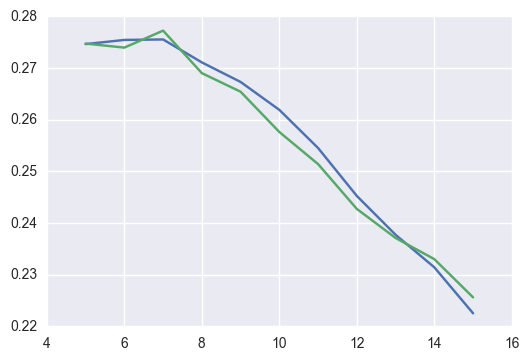

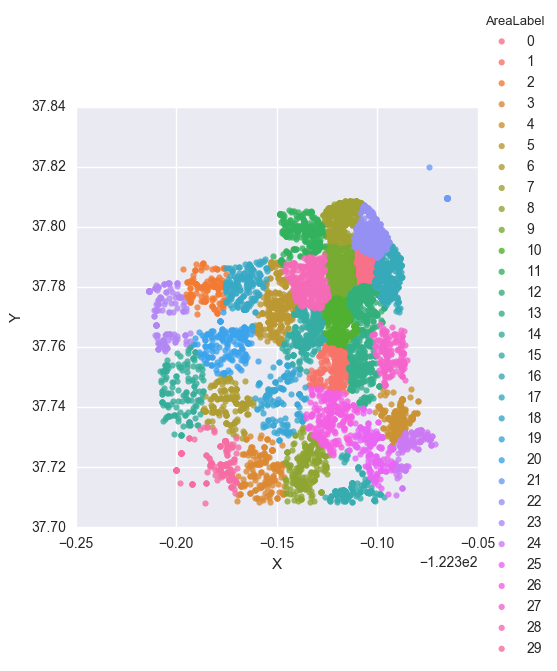

/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running algorithms for clusters = 35
Logistic classification results:
(0.28292131175752089, 0.0063080476170170466)
Decision tree results:
(0.27540809112688402, 0.0058058128697023583, 5)
random forest classification results:
(0.27650442560411365, 0.0029744844771215253)


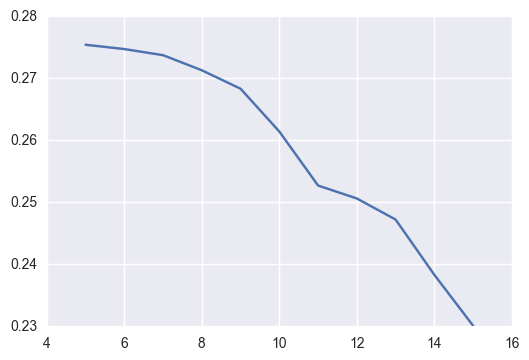

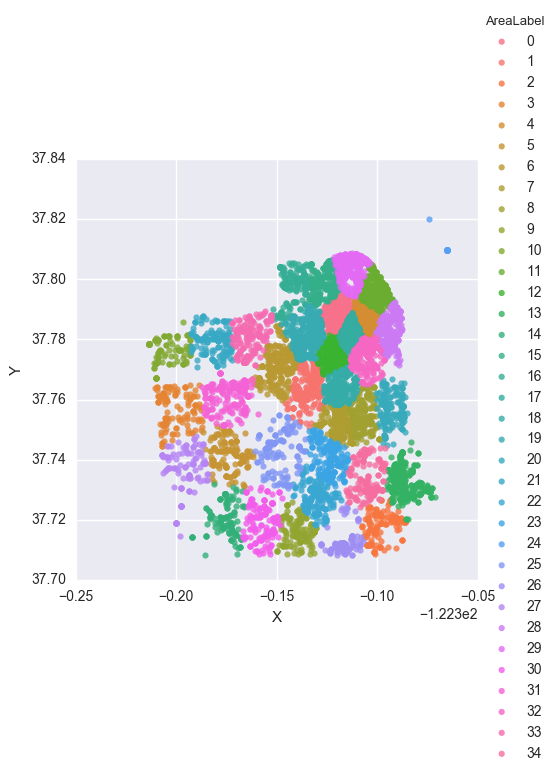

/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running algorithms for clusters = 40
Logistic classification results:
(0.28242139669100902, 0.0066077007352492809)
Decision tree results:
(0.27822354154877388, 0.0064810574395758906, 6)
random forest classification results:
(0.2752930585634758, 0.0014832332091914561)


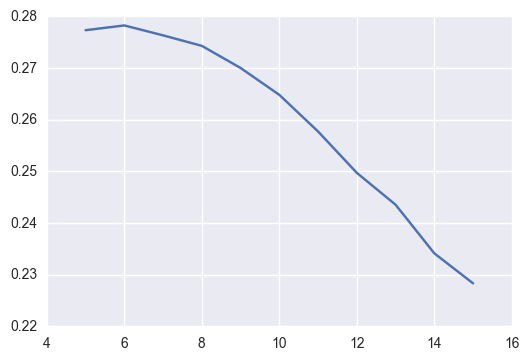

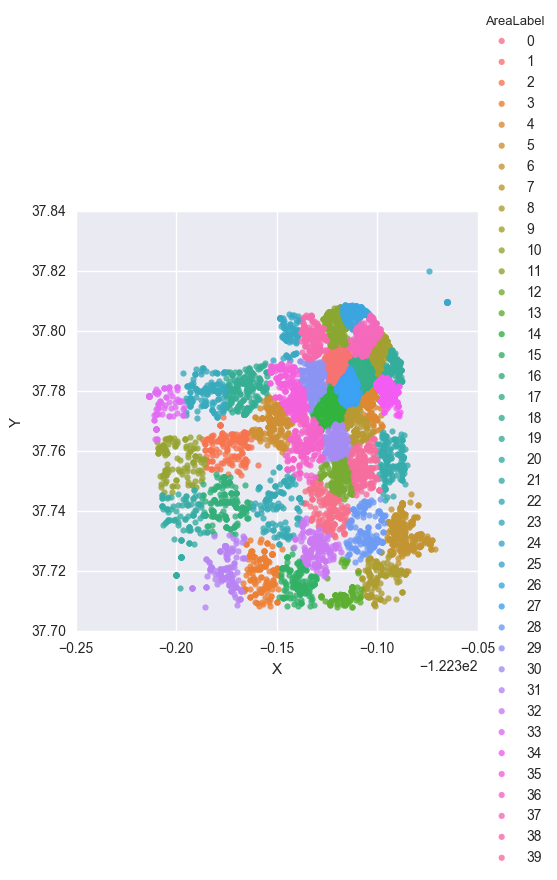

In [25]:
def applyAlgorithmsToScenario(train, targetVariable, maxDataframeSize):
    # basic features
    featureList = ['X', 'Y']
    
    trainingData = train[:maxDataframeSize]
    
    # hourly & isWeekEnd feature engineering
    extendDataWithHourOfTheDay(trainingData, featureList)
    extendDataWithDayType(trainingData, featureList)
    
    X = trainingData[featureList]
    y = trainingData[targetVariable]
    
    executeLogisticRegression(X, y)
    executeDecisionTreeClassifier(X, y)
    executeRandomForest(X, y)
    
    for numOfClusters in range(30, 41, 5):
        featuresKMeans = []
        featuresKMeans.extend(featureList)
        dataKMeans = trainingData[:maxDataframeSize]
        extendDataWithClusters(dataKMeans, featuresKMeans, numOfClusters)
        X_KMeans = dataKMeans[featuresKMeans]
        Y_KMeans = dataKMeans[targetVariable]
        
        print "Running algorithms for clusters = " + str(numOfClusters)
        executeLogisticRegression(X_KMeans, Y_KMeans)
        executeDecisionTreeClassifier(X_KMeans, Y_KMeans)
        executeRandomForest(X_KMeans, Y_KMeans)
        
        sns.lmplot('X', 'Y', data=dataKMeans, hue='AreaLabel', fit_reg=False)
        plt.show()
        
        print ""
        
applyAlgorithmsToScenario(train, targetVariable, 10000)    

In [231]:
#################################
## naive bayes & vectorize #####
################################

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

def KFoldTestText(inputDataframe, textColumnName, targetColumnName):
    kfold = KFold(n=len(inputDataframe), n_folds = 5)
    scores = []
    
    for trainIndices, testIndices in kfold:
        
        X_train = inputDataframe.iloc[trainIndices][textColumnName].values
        y_train = inputDataframe.iloc[trainIndices][targetColumnName].values
        count_vectorizer = CountVectorizer()
        X_train = count_vectorizer.fit_transform(X_train)
        classifier = MultinomialNB()
        classifier.fit(X_train, y_train)
        
        X_test = inputDataframe.iloc[testIndices][textColumnName].values
        y_test = inputDataframe.iloc[testIndices][targetColumnName].values
        X_test = count_vectorizer.transform(X_test)
        X_predicted = classifier.predict(X_test)
        
        scores.append( f1_score(y_test, X_predicted) )
        
    print (np.mean(scores), np.std(scores))  
        
    
KFoldTestText(train[:5000], "Descript", "Category")



/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
 

(0.9606814130060668, 0.01398432700452471)


/Users/user/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [168]:
# sns.lmplot('X', 'Y', data=X_forKMeans, hue='AreaLabel', fit_reg=False)

In [26]:
# apply feature engineering 

print "exteding day and hour info"
extendDataWithDayOfTheWeek(train, numericalFeatures)
extendDataWithHourOfTheDay(train, numericalFeatures)

exteding day and hour info
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


In [27]:
features = numericalFeatures #+ ["HourOfDay", "DayOfWeek"]
print features
X = train[features]
y = train[targetVariable]

['X', 'Y', 'DayOfTheWeek', 'HourOfTheDay']


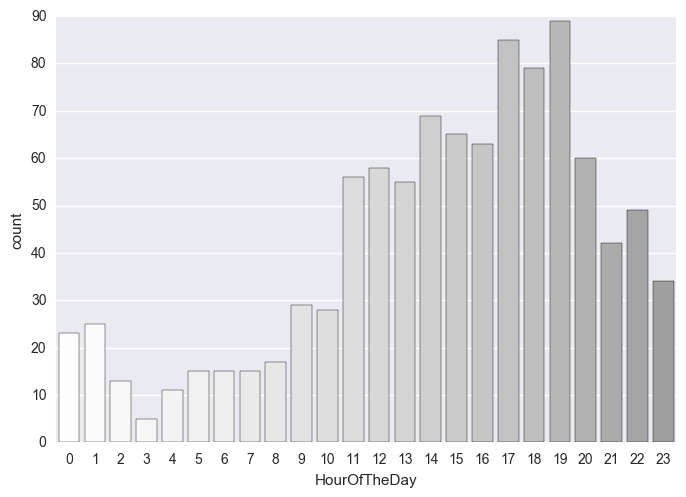

In [45]:
# Visualization

# visualization on subsets
smallTrain = train[:1000]

import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="HourOfTheDay", 
                   data=smallTrain, 
                   palette=sns.color_palette("Greys", 50))

In [260]:
print featuresForVisualization
print train[:2]

['X', 'Y', '7DeadlySins', 'SimpleSins', 'HourOfTheDay']
                 Dates        Category                  Descript  DayOfWeek  \
0  2015-05-13 23:53:00        WARRANTS            WARRANT ARREST  Wednesday   
1  2015-05-13 23:53:00  OTHER OFFENSES  TRAFFIC VIOLATION ARREST  Wednesday   

  PdDistrict      Resolution             Address           X          Y  \
0   NORTHERN  ARREST, BOOKED  OAK ST / LAGUNA ST -122.425892  37.774599   
1   NORTHERN  ARREST, BOOKED  OAK ST / LAGUNA ST -122.425892  37.774599   

  7DeadlySins SimpleSins  HourOfTheDay  
0      others     others            23  
1      others     others            23  


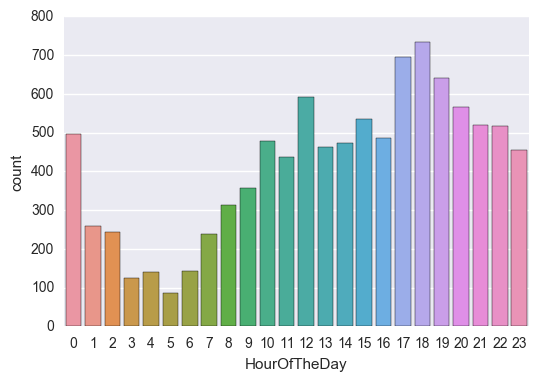

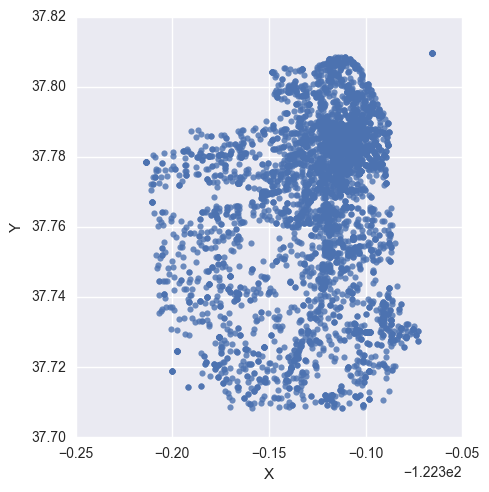

In [255]:
sns.lmplot('X', 'Y', data=train2, fit_reg=False)

plt.show()

In [256]:
print "exteding crime categories"

featuresForVisualization = []
featuresForVisualization.extend(numericalFeatures)

extendTrainingWithCrimeCategories(train, featuresForVisualization)
extendDataWithHourOfTheDay(train, featuresForVisualization)

exteding crime categories
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


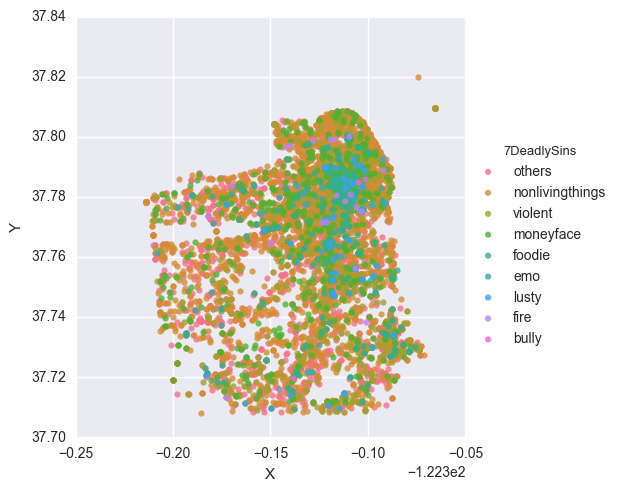

In [258]:
sns.lmplot('X', 'Y', data=train, hue='7DeadlySins', fit_reg=False)

plt.show()

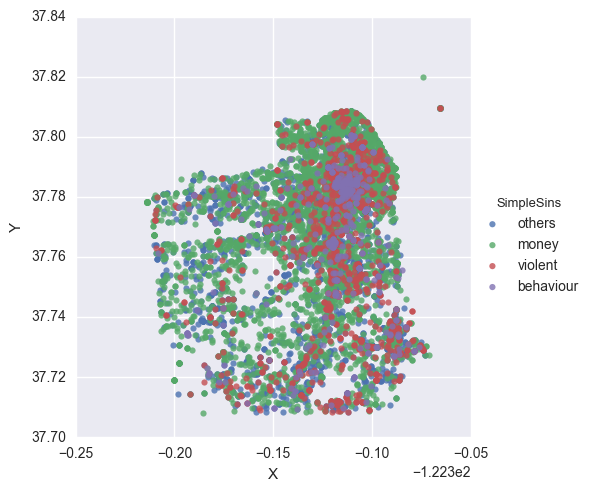

In [259]:
sns.lmplot('X', 'Y', data=train, hue='SimpleSins', fit_reg=False)

plt.show()

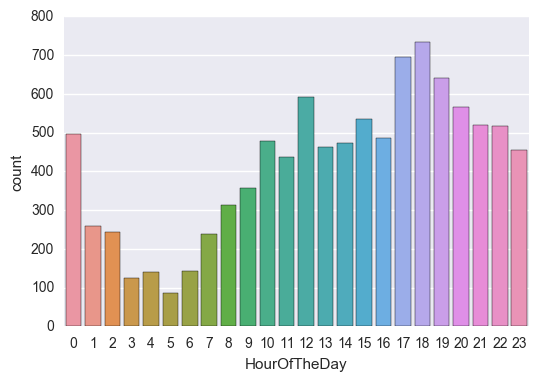

In [261]:
ax = sns.countplot(x="HourOfTheDay",  data=train)

In [265]:
extendDataWithDayType(train, [])
train[:2]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,7DeadlySins,SimpleSins,HourOfTheDay,IsWeekend
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,others,others,23,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,others,others,23,1


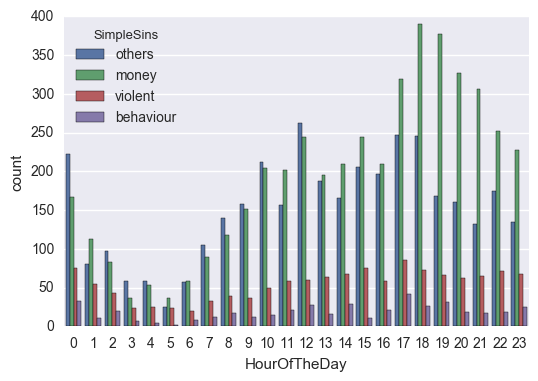

In [253]:
#print train
ax = sns.countplot(x="HourOfTheDay", hue="SimpleSins", data=train)